In [1]:
import quandl
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
plt.style.use("ggplot")
%matplotlib inline

from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from scipy import stats

from itertools import product

In [2]:
data = quandl.get("FMSTREAS/MTS")

In [3]:
data.tail()

,Receipts,Outlays,Deficit/Surplus (-),Borrowing from the Public,Reduction of Operating Cash,By Other Means
Date,,,,,,
2016-05-16,224603.0,277111.0,52507.0,45221.0,40675.0,-33388.0
2016-06-16,329572.0,323320.0,-6252.0,46080.0,-65245.0,12913.0
2016-07-16,209998.0,322817.0,112815.0,66778.0,29914.0,16123.0
2016-08-16,231327.0,338438.0,107112.0,105761.0,44802.0,-43452.0
2016-09-16,356537.0,323178.0,-33359.0,68480.0,-64365.0,-37474.0


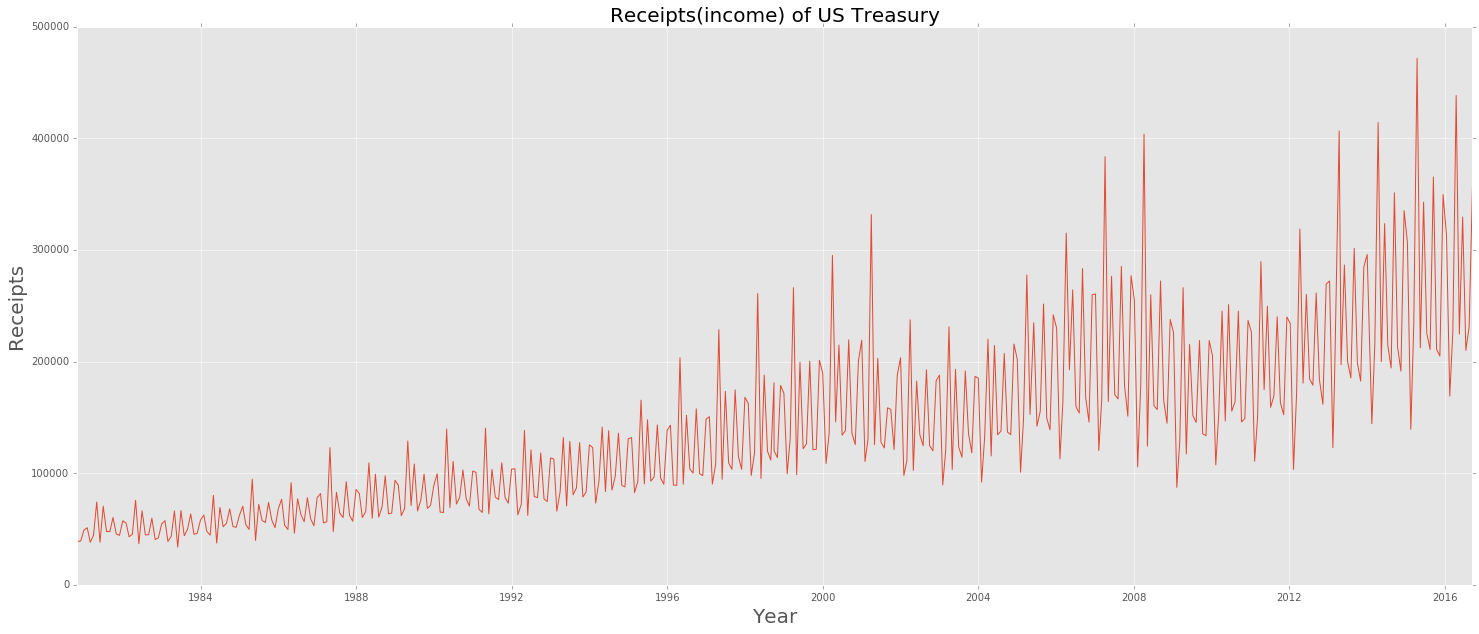

In [4]:
plt.figure(figsize=(25,10))
plt.title("Receipts(income) of US Treasury", fontsize=20)

plt.plot(data.index, data.Receipts)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Receipts", fontsize=20)


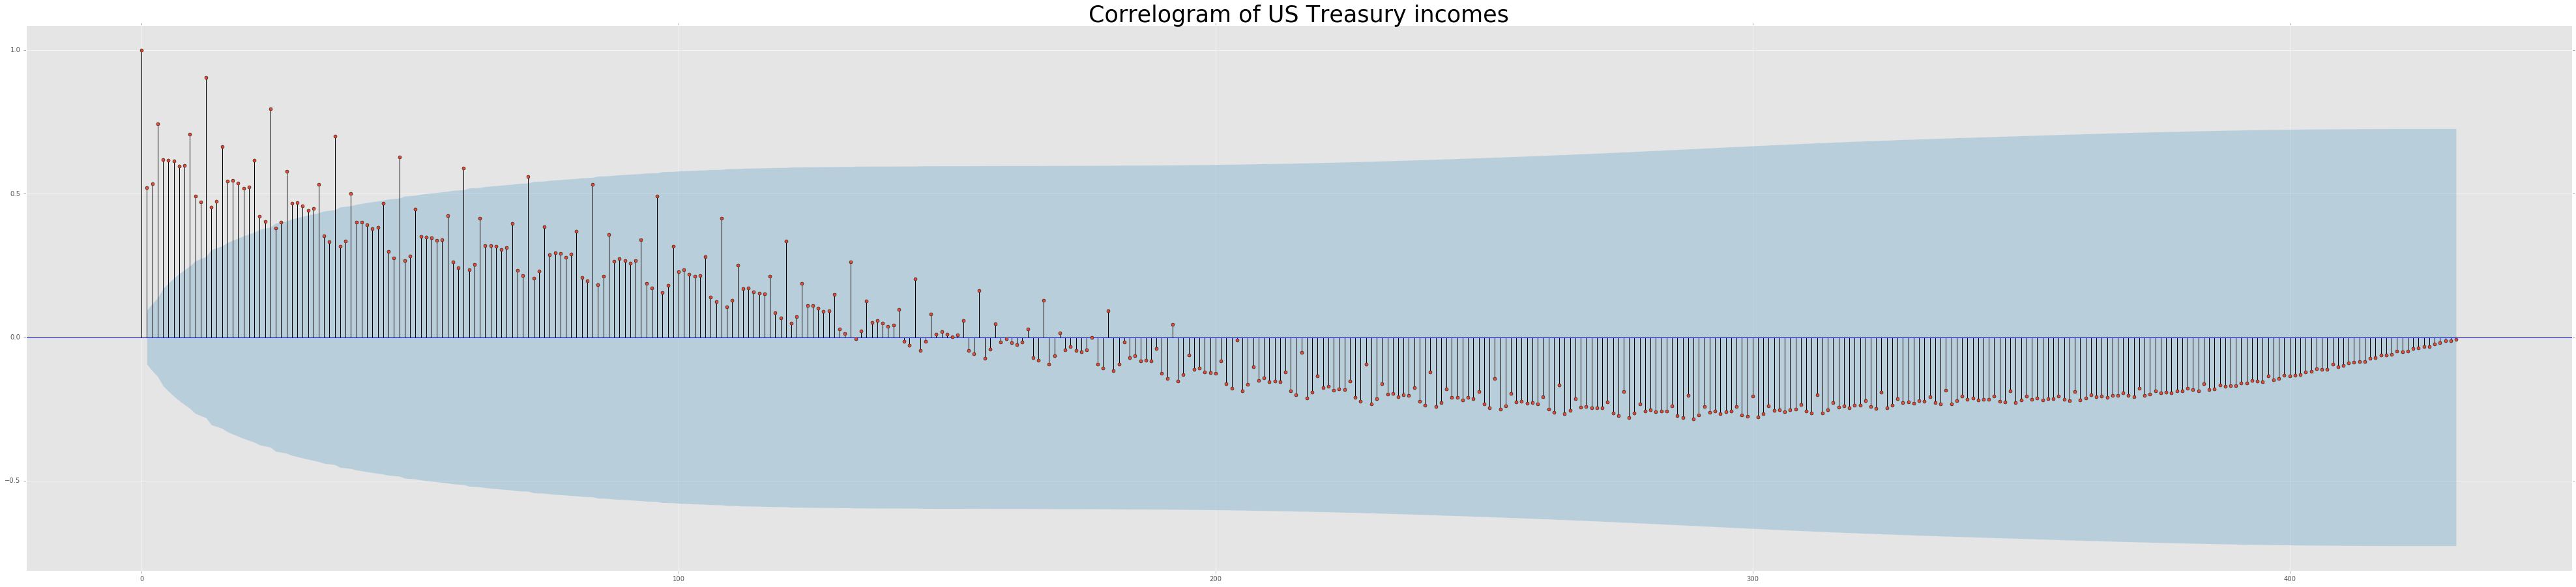

In [5]:
fig = tsaplots.plot_acf(data.Receipts, ax=None)
plt.title("Correlogram of US Treasury incomes", fontsize=35)
fig.set_figwidth(70)
fig.set_figheight(15)

Видим, что на короллелограмме выходят из коридора
Проверим гипотезу о стационарности ряда с помощью критерия Дика-Фуллера

Критерий Дики-Фуллера: p=0.900985


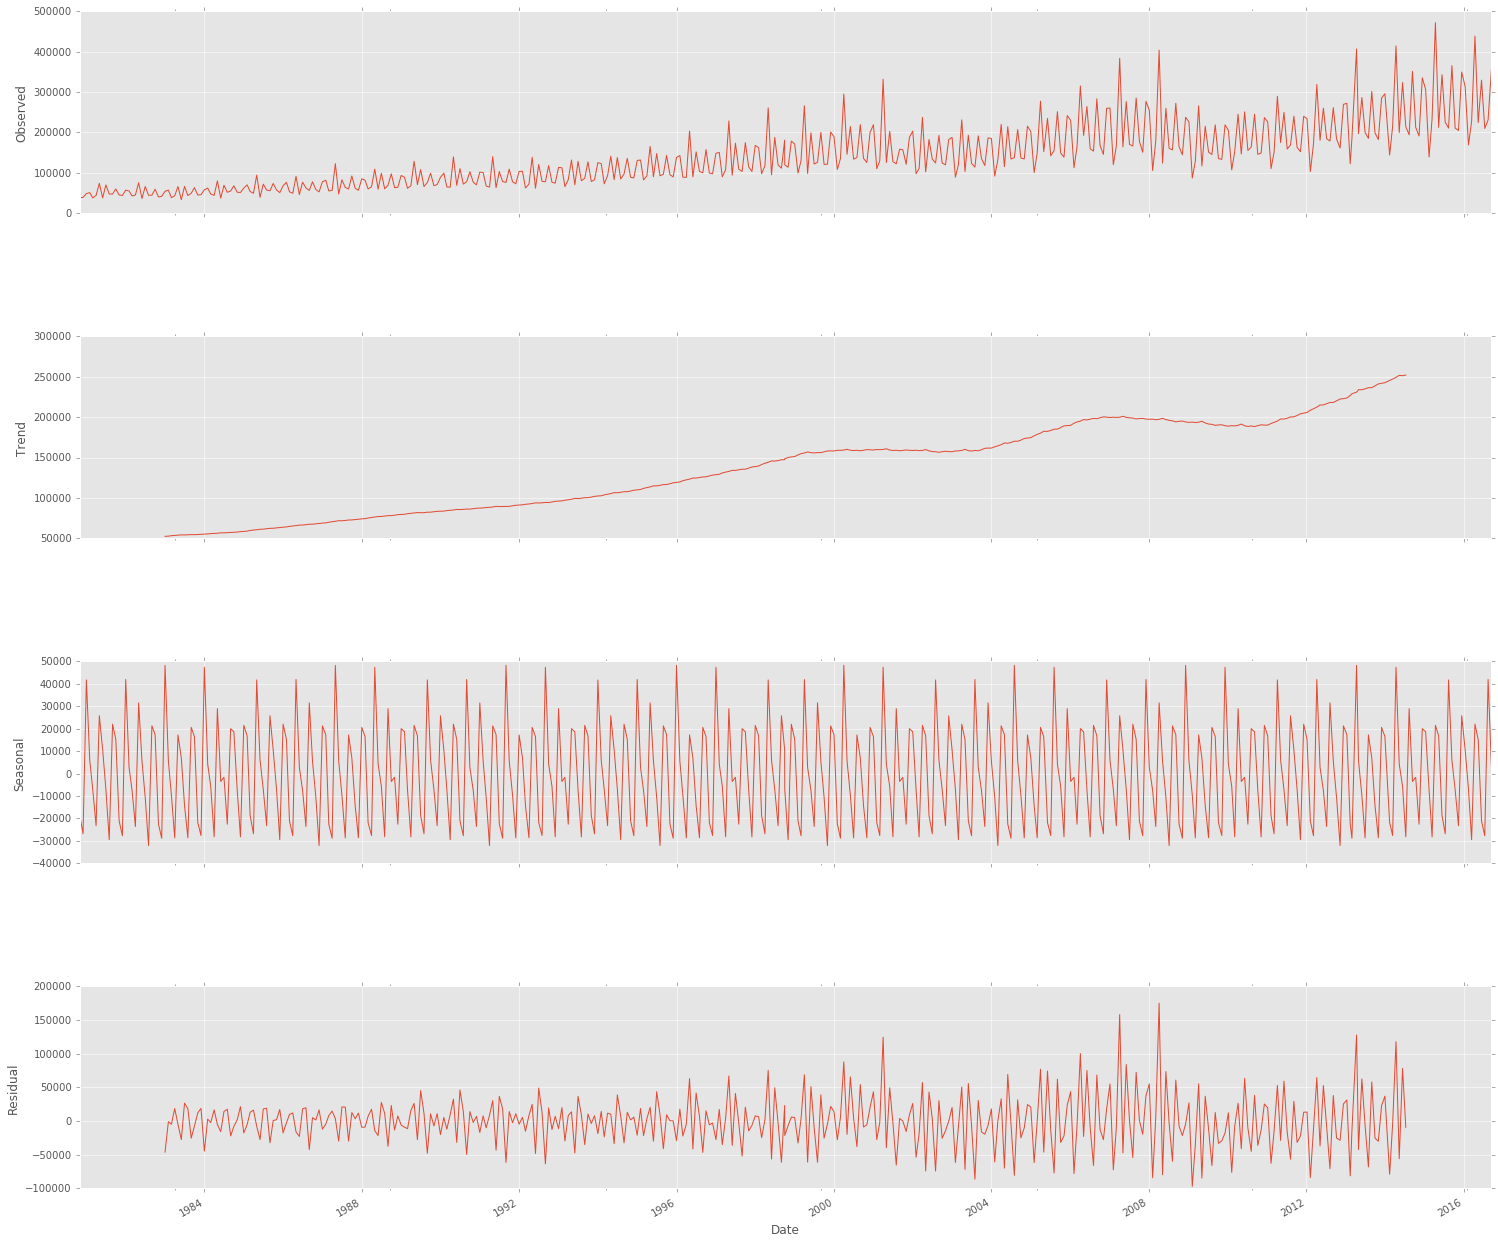

In [6]:
fig = sm.tsa.seasonal_decompose(data["Receipts"], freq=52).plot()
fig.set_figwidth(25)
fig.set_figheight(22)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Receipts)[1])
#ряд нестационарен

* Полученное $p-$value показывает, что мы не отвергаем нулевую гипотезу о нестационарности ряда
* По изображению выше видим, что исходный ряд нестационарен(график Trend из STL-декомпозиции)
* Также, хорошо видим сезонность по Seasonal 
* Бокс-Кокс
* Дифферинцируем сезонно
* Дифферинциируем

Критерий Дики-Фуллера: p=0.000162


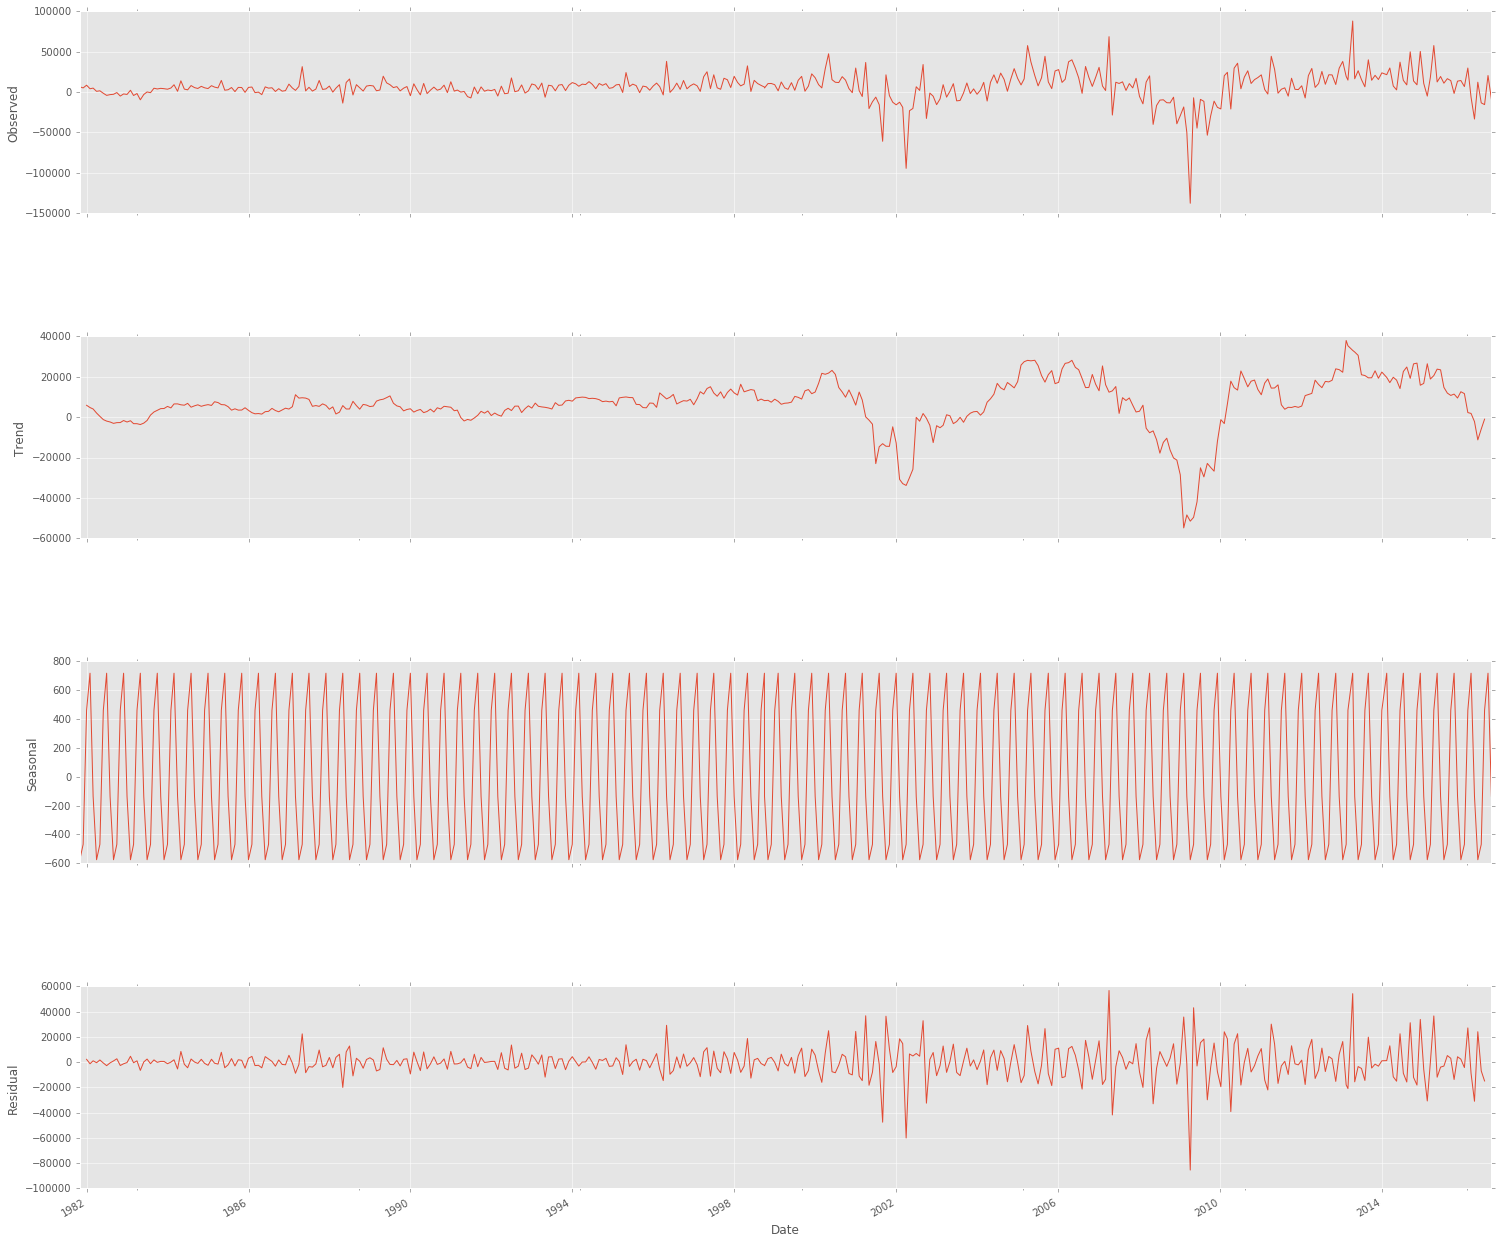

In [7]:
data['Receipts_season'] = data.Receipts - data.Receipts.shift(12)
fig = sm.tsa.seasonal_decompose(data.Receipts_season[12:], freq=5).plot()
fig.set_figwidth(25)
fig.set_figheight(22)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Receipts_season[12:])[1])

* Можем видеть, что после сезонного дифференцирования(с периодом 12 месяцев) тренда больше не наблюдается
* Более того, $p$-value показывает, что нулевая гипотеза о нестационарности отвергается
* Построим коррелограмму продифференцированного ряда

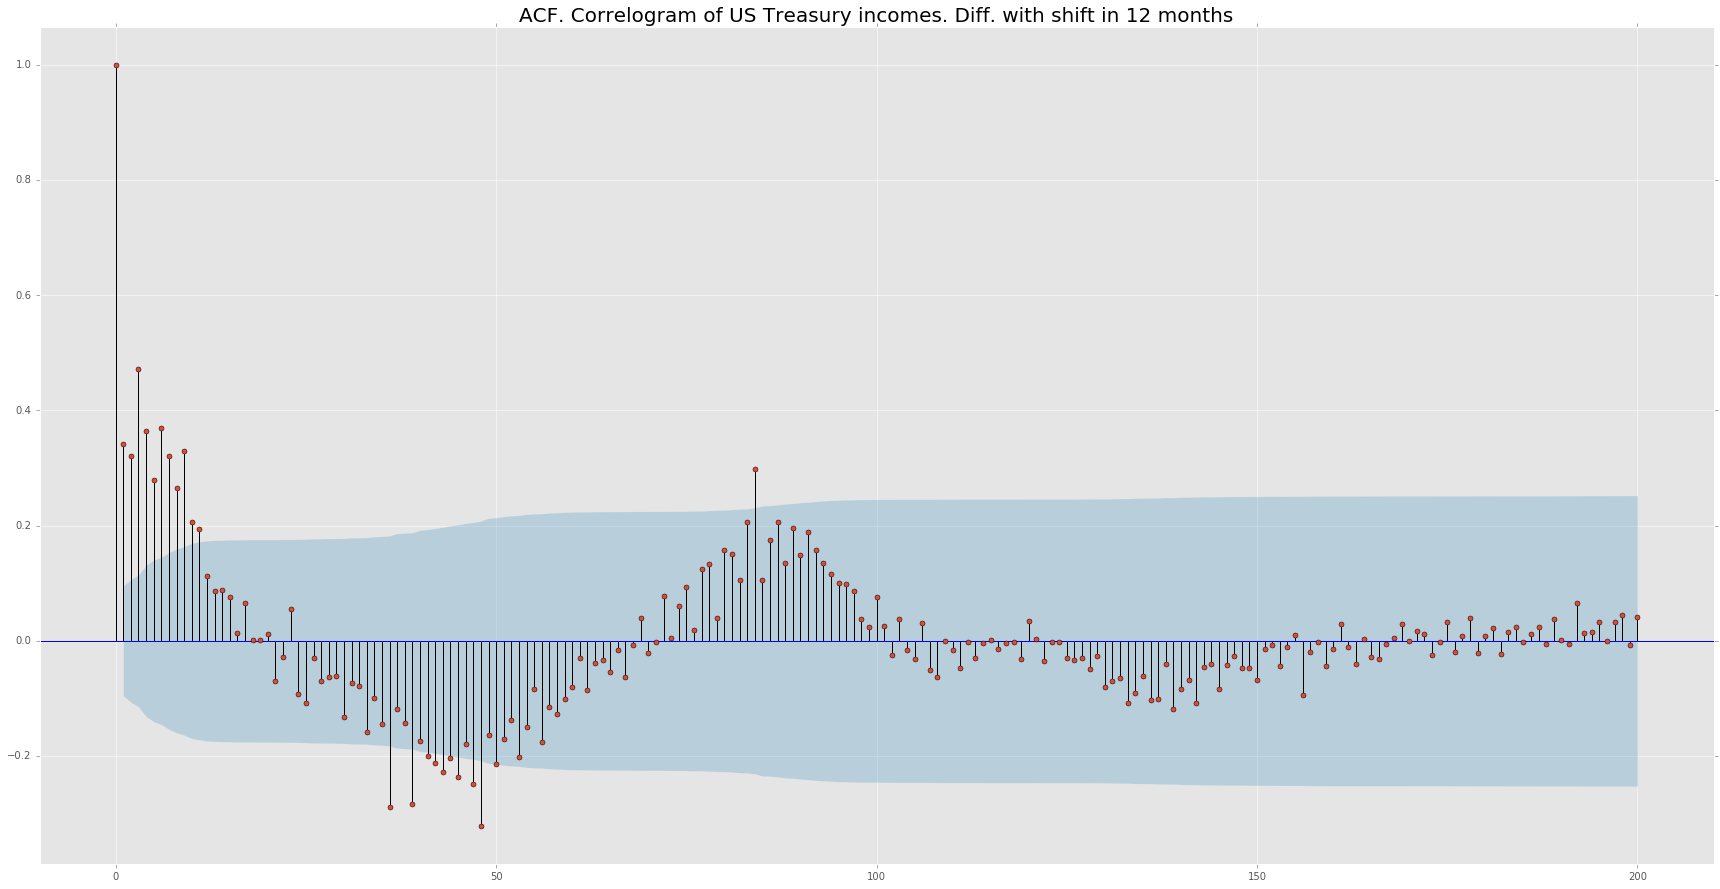

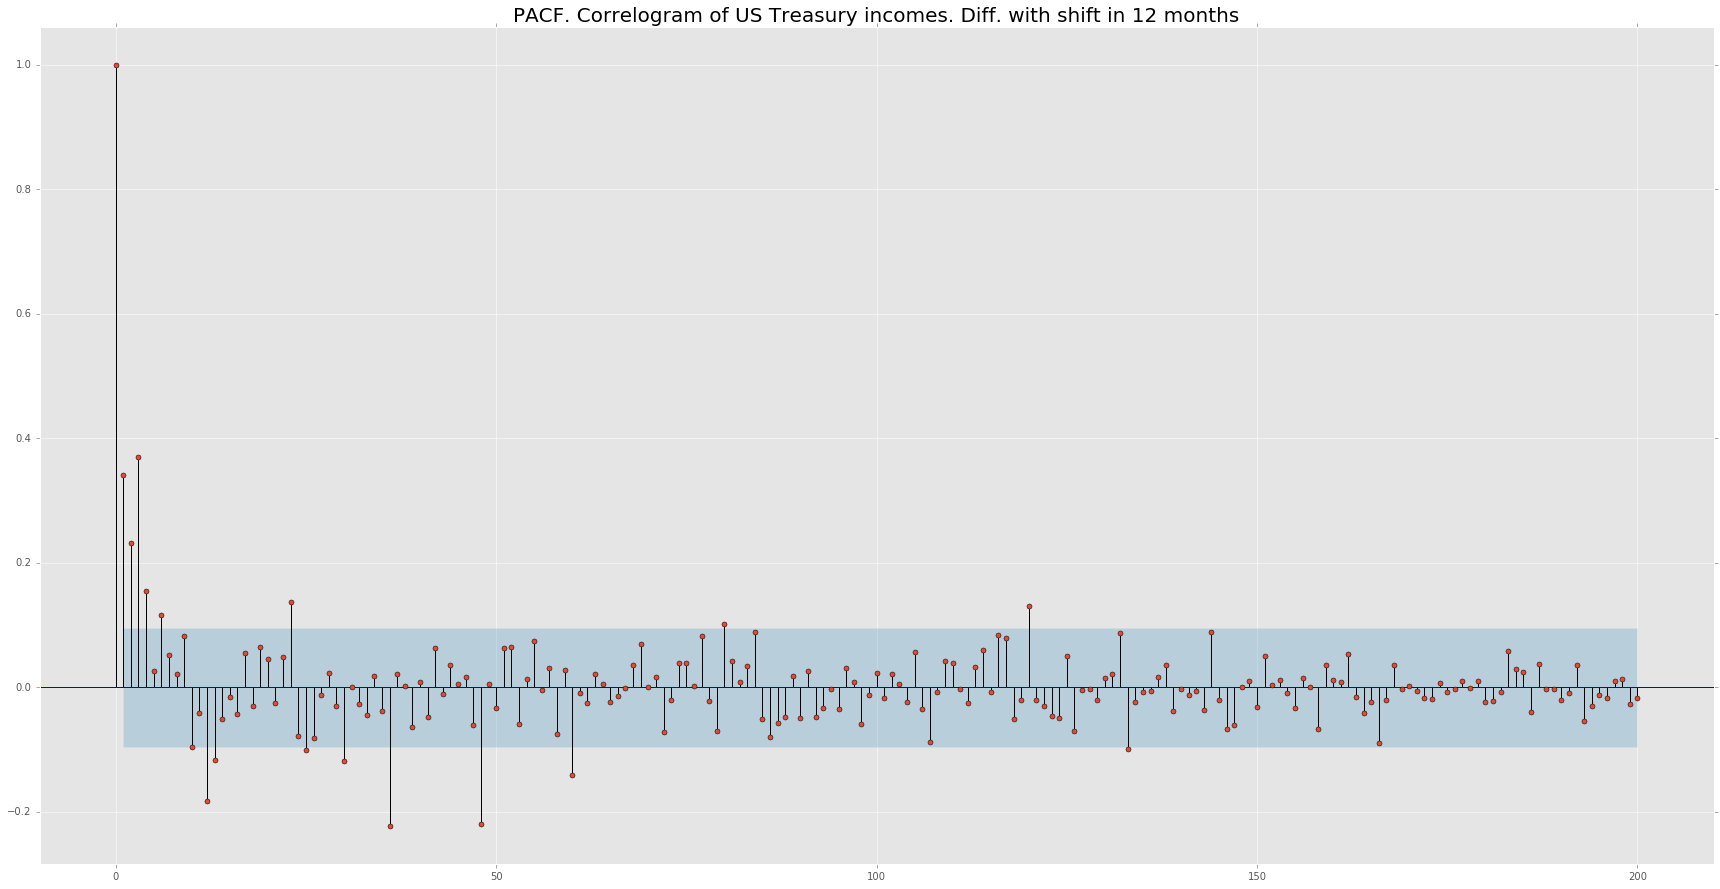

In [8]:
fig = tsaplots.plot_acf(data.Receipts_season[12:], ax=None, lags=200)
plt.title("ACF. Correlogram of US Treasury incomes. Diff. with shift in 12 months", fontsize=20)
fig.set_figwidth(30)
fig.set_figheight(15)

fig = tsaplots.plot_pacf(data.Receipts_season[12:], ax=None, lags=200)
plt.title("PACF. Correlogram of US Treasury incomes. Diff. with shift in 12 months", fontsize=20)
fig.set_figwidth(30)
fig.set_figheight(15)

* максимальный сезонный лаг(выходящий из синего "коридора", значимо отличающееся значение автокорреляции) принимает значение 48, значит начальным приближением для $Q$ будет 3(или 4)
* кол-во значимо отличимых от нуля  значений автокорреляции на ACF равно 12 - это будет начальным приближением для $q$
* $P$ - 10, т.к. номер последнего значения автокорреляции значимо отличающейся от нуля соответствует 120
* $p$ - 4, количество значимо отличимых от нуля несезонных значений автокорреляций на PACF

In [12]:
p_range = range(0, 4)
q_range = range(0, 3)
P_range = range(0, 2)
Q_range = range(0, 3)
d, D = 1, 1


parameters = product(p_range, q_range, P_range, Q_range)
parameters_list = list(parameters)
len(parameters_list)

72

In [13]:
%%time
results = []
best_aic = float("inf")
#warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Receipts_season, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    print("model with params", param, "done")
    
#warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
model with params (0, 0, 0, 1) done
model with params (0, 0, 0, 2) done
model with params (0, 0, 1, 0) done
model with params (0, 0, 1, 1) done
model with params (0, 0, 1, 2) done
model with params (0, 1, 0, 0) done
model with params (0, 1, 0, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (0, 1, 0, 2) done
model with params (0, 1, 1, 0) done
model with params (0, 1, 1, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (0, 1, 1, 2) done
model with params (0, 2, 0, 0) done
model with params (0, 2, 0, 1) done
model with params (0, 2, 0, 2) done
model with params (0, 2, 1, 0) done
model with params (0, 2, 1, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (0, 2, 1, 2) done
model with params (1, 0, 0, 0) done
model with params (1, 0, 0, 1) done
model with params (1, 0, 0, 2) done
model with params (1, 0, 1, 0) done
model with params (1, 0, 1, 1) done
model with params (1, 0, 1, 2) done
model with params (1, 1, 0, 0) done
model with params (1, 1, 0, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (1, 1, 0, 2) done
model with params (1, 1, 1, 0) done
model with params (1, 1, 1, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (1, 1, 1, 2) done
model with params (1, 2, 0, 0) done
model with params (1, 2, 0, 1) done
model with params (1, 2, 0, 2) done
model with params (1, 2, 1, 0) done
model with params (1, 2, 1, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (1, 2, 1, 2) done
model with params (2, 0, 0, 0) done
model with params (2, 0, 0, 1) done
model with params (2, 0, 0, 2) done
model with params (2, 0, 1, 0) done
model with params (2, 0, 1, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (2, 0, 1, 2) done
model with params (2, 1, 0, 0) done
model with params (2, 1, 0, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (2, 1, 0, 2) done
model with params (2, 1, 1, 0) done
model with params (2, 1, 1, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (2, 1, 1, 2) done
model with params (2, 2, 0, 0) done
model with params (2, 2, 0, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (2, 2, 0, 2) done
model with params (2, 2, 1, 0) done
model with params (2, 2, 1, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (2, 2, 1, 2) done
model with params (3, 0, 0, 0) done
model with params (3, 0, 0, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (3, 0, 0, 2) done
model with params (3, 0, 1, 0) done
model with params (3, 0, 1, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (3, 0, 1, 2) done
model with params (3, 1, 0, 0) done
model with params (3, 1, 0, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (3, 1, 0, 2) done
model with params (3, 1, 1, 0) done
model with params (3, 1, 1, 1) done


/home/rudolph/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model with params (3, 1, 1, 2) done
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 0, 2)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (3, 2, 1, 2)
CPU times: user 11min 42s, sys: 21min 1s, total: 32min 43s
Wall time: 9min 15s


Критерий Стьюдента: p=0.771904
Критерий Дики-Фуллера: p=0.000000


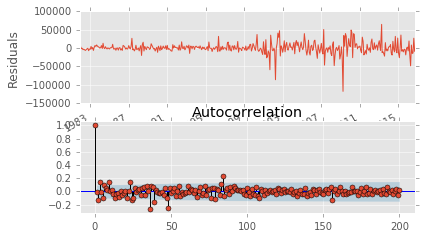

In [14]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=200, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

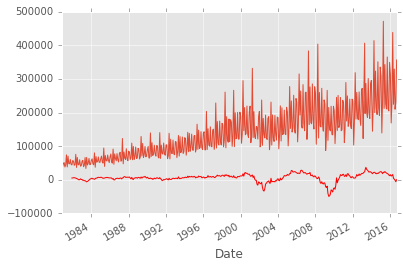

In [16]:
data["pred"] = best_model.fittedvalues
data.Receipts.plot()
data.pred[13:].plot(color='r')